In [2]:
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask

import seaborn as sns

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as imag
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as mticker
import types


import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import csv
import pandas as pd
import os

from mpl_toolkits.basemap import Basemap
bm = Basemap()

import types
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left")
    self.offsetText.set_position(
            (0, bottom - self.OFFSETTEXTPAD * self.figure.dpi / 72.0))


def register_bottom_offset(axis, func):
    axis._update_offset_text_position = types.MethodType(func, axis)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [6]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [3]:
path_to_file = '/fast/gmooers/Preprocessed_Data/Paper_Annual/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/Paper_Full_2018.nc'
predict_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Preprocessed_Data/CAM_Paper_Annual.nc'
cam_ds = xr.open_dataset(path_to_file)

In [5]:
precip_spcam_ds = real_ds.targets[:, -1].values
precip_dnn_ds = predict_ds.Prediction.values
precip_cam_ds = cam_ds.PRECT.values

times = real_ds.time.values

lats = np.linspace(-90.0, 90.0, 96)
lons = np.linspace(0.0, 357.5, 144)

Xvar, Yvar = np.meshgrid(lons, lats)

x = 144
y = 96
z = 30
t = int(len(precip_spcam_ds)/(x*y))
print(t)

34176


In [10]:
print(precip_spcam_ds.shape)
print(precip_dnn_ds.shape)
print(precip_cam_ds.shape)

(472449024,)
(472449024,)
(35040, 96, 144)


In [11]:
precip_spcam5 = np.zeros(shape=(t, y, x))
precip_DNN = np.zeros(shape=(t, y, x))

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = precip_spcam_ds[count]
            B = precip_dnn_ds[count]
            precip_spcam5[i, j, k] = A*86400000.
            precip_DNN[i, j, k] = B*86400000
            count = count + 1

In [12]:
truths = np.nanmean(precip_spcam5, axis = 0)
predictions = np.nanmean(precip_DNN, axis = 0)
diff = predictions-truths

precip_levels = np.linspace(-2,26,15)
diff_levels = np.linspace(-2.5,2.5,26)

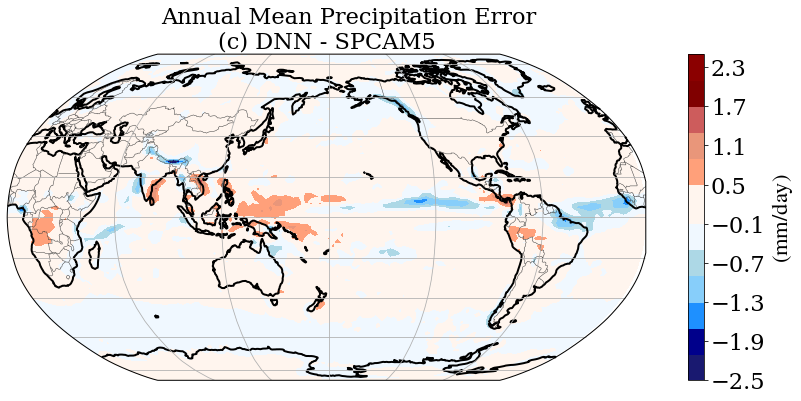

In [15]:
cmap = matplotlib.colors.ListedColormap(["mediumblue","blue", "deepskyblue", "aquamarine", "lightgreen","limegreen","greenyellow","yellow","gold","orange","orangered","red","mediumvioletred","purple"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N) 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(15,6)

cmap = matplotlib.colors.ListedColormap(["midnightblue","darkblue","dodgerblue","lightskyblue","lightblue","aliceblue","seashell","lightsalmon","darksalmon","indianred","maroon","darkred"])
norm = matplotlib.colors.BoundaryNorm(np.arange(1,5), cmap.N)
contour_plot = ax.contourf(Xvar, Yvar, diff,diff_levels,cmap=cmap, vmin =-2.5, vmax=2.5, transform=ccrs.PlateCarree())
#fig.subplots_adjust(right=0.8)
#cbaxes = fig.add_axes([0.82, 0.12, 0.05, 0.23])
cbar = plt.colorbar(contour_plot, label=r'$\left(\mathrm{mm/day}\right)$') 
ax.set_title('(c) DNN - SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Annual Mean Precipitation Error", y=0.99, x=0.47, fontsize = fz)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Annual_Precip_Error.npy", diff)

In [53]:
path_to_file = '/fast/gmooers/Models/Paper_Full_2018_Primative.nc'
primative_ds = xr.open_dataset(path_to_file)
primative_dnn_ds = primative_ds.Prediction.values*86400000.

In [54]:
primative_dnn = np.zeros(shape=(t, y, x))

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = primative_dnn_ds[count]
            primative_dnn[i, j, k] = A
            count = count + 1

In [20]:
precip_cam_ds = precip_cam_ds*86400000.

In [55]:
D = precip_DNN.ravel()
PD = primative_dnn.ravel()
T = precip_spcam5.ravel()
C = precip_cam_ds.ravel()

In [56]:
max_values = [np.nanmax(D), np.nanmax(T), np.nanmax(C)]
min_values = [np.nanmin(D),  np.nanmin(T),  np.nanmin(C)]
m = min(min_values)
M = max(max_values)

In [57]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Prediction.npy",D)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Primative_Prediction.npy",PD)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_SPCAM5_Precip_Truth.npy",T)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_CAM5_PRECIP.npy",C)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Precip_Max_Scalar.npy",m)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Precip_Min_Scalar.npy",M)

In [58]:
ocean_DNN = np.zeros(shape=(t, y, x))
ocean_Primative_DNN = np.zeros(shape=(t, y, x))
ocean_SPCAM5 = np.zeros(shape=(t, y, x))
ocean_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

ocean_DNN[:,:,:] = np.nan
ocean_SPCAM5[:,:,:] = np.nan
ocean_CAM5[:,:,:] = np.nan


for i in range(len(ocean_DNN[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_DNN[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == False:
            ocean_DNN[:, j, i] = precip_DNN[:, j, i]
            ocean_Primative_DNN[:,j,i] = primative_dnn[:,j,i] 
            ocean_SPCAM5[:, j, i] =  precip_spcam5[:, j, i]
            
for i in range(len(ocean_CAM5[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_CAM5[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == False:
            ocean_CAM5[:, j, i] = precip_cam_ds[:, j, i]
        

print('ocean masks applied')

ocean masks applied


In [59]:
land_DNN = np.zeros(shape=(t, y, x))
land_Primiative_DNN = np.zeros(shape=(t, y, x))
land_SPCAM5 = np.zeros(shape=(t, y, x))
land_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

land_DNN[:,:,:] = np.nan
land_SPCAM5[:,:,:] = np.nan
land_CAM5[:,:,:] = np.nan


for i in range(len(land_DNN[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_DNN[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == True:
            land_DNN[:, j, i] = precip_DNN[:, j, i]
            land_Primiative_DNN[:,j,i] = primative_dnn[:,j,i]
            land_SPCAM5[:, j, i] = precip_spcam5[:, j, i]
            
for i in range(len(land_CAM5[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_CAM5[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == True:
            land_CAM5[:, j, i] = precip_cam_ds[:, j, i]
        

print('land masks applied')

land masks applied


In [60]:
C_ocean = ocean_CAM5.ravel()
C_land = land_CAM5.ravel()

D_ocean = ocean_DNN.ravel()
D_land = land_DNN.ravel()

DP_ocean = ocean_Primative_DNN.ravel()
DP_land = land_Primiative_DNN.ravel()

T_ocean = ocean_SPCAM5.ravel()
T_land = land_SPCAM5.ravel()

In [61]:
ocean_max_values = [np.nanmax(D_ocean), np.nanmax(T_ocean), np.nanmax(C_ocean)]
ocean_min_values = [np.nanmin(D_ocean),  np.nanmin(T_ocean),  np.nanmin(C_ocean)]
m_ocean = min(ocean_min_values)
M_ocean = max(ocean_max_values)
land_max_values = [np.nanmax(D_land), np.nanmax(T_land), np.nanmax(C_land)]
land_min_values = [np.nanmin(D_land),  np.nanmin(T_land),  np.nanmin(C_land)]
m_land = min(land_min_values)
M_land = max(land_max_values)

In [62]:
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_SPCAM5_Precip_Prediction.npy",D_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_SPCAM5_Precip_Primative_Prediction.npy",DP_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_SPCAM5_Prepip_Truth.npy",T_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_CAM5_PRECIP.npy",C_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_Precip_Max_Scalar.npy",m_ocean)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Ocean_Precip_Min_Scalar.npy",M_ocean)

#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_SPCAM5_Precip_Prediction.npy",D_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_SPCAM5_Precip_Primative_Prediction.npy",DP_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_SPCAM5_Prepip_Truth.npy",T_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_CAM5_PRECIP.npy",C_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_Precip_Max_Scalar.npy",m_land)
#np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/Paper_Land_Precip_Min_Scalar.npy",M_land)


print("precip data saved")

precip data saved


In [63]:
def array_generator(min_val, max_val, percentage):
    listing = []
    for i in range(300):
        if i == 0:
            temp_val = min_val
            listing.append(temp_val)
        else:
            if temp_val < max_val:
                temp_val = temp_val*percentage
                listing.append(temp_val)
        
    print(len(listing))
    return np.array(listing)
#array_generator(0.03, maxi, 1.07)

300


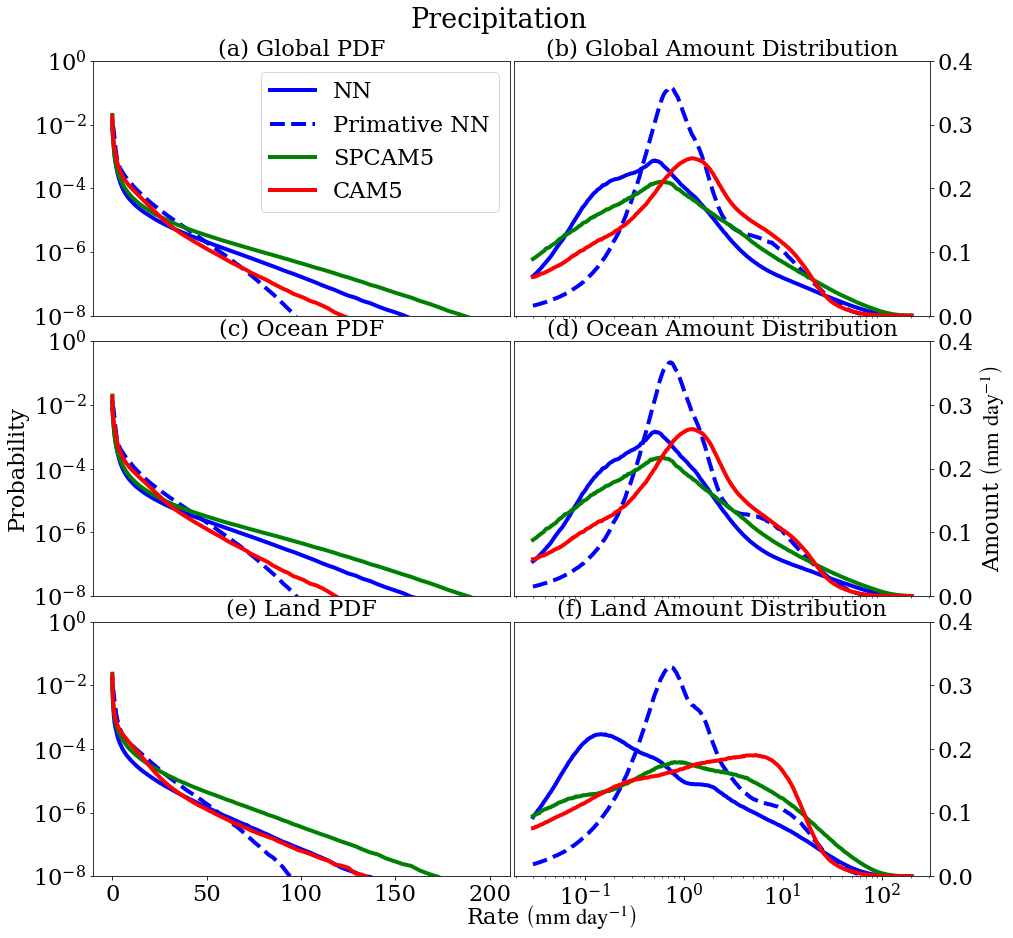

In [64]:
bins = array_generator(0.03, M, 1.03)



fig, ax = plt.subplots(3,2,figsize=(15,15))

shared_bins = np.histogram_bin_edges(D, bins=bins, range=(0, M))
freq, edges = np.histogram(D, bins = shared_bins, density=True)
bad_freq, bad_edges = np.histogram(PD, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C, bins = shared_bins, density=True)

ax[0,1].set_xscale("log")
ax[1,1].set_xscale("log")
ax[2,1].set_xscale("log")

ax[0,0].plot(edges[:-1], freq/np.sum(freq),  label = "NN", color = 'blue')
ax[0,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq),  label = "Primative NN", color = 'blue', linestyle="--")
ax[0,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), label = "SPCAM5", color = 'green')
ax[0,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams), label = "CAM5", color = 'red')
ax[0,0].set_ylim(1e-8, 1)

ax[2,0].set_xlabel('Rate '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[2,0].xaxis.set_label_coords(1.1,-0.1)
ax[1,0].set_ylabel('Probability', fontsize = fz)
ax[0,0].set_title('(a) Global PDF', fontsize = fz)
ax[1,0].set_title('(c) Ocean PDF', fontsize = fz)
ax[2,0].set_title('(e) Land PDF', fontsize = fz)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks([])
    
totals = freq*edges[:-1]
bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
    
ax[0,1].plot(edges[:-1], totals,  label = "DNN", color = 'blue')
ax[0,1].plot(bad_edges[:-1], bad_totals,  label = "Primative DNN", color = 'blue', linestyle="--")
ax[0,1].plot(edges_targ[:-1], totals_targ, label = "SPCAM5", color = 'green')
ax[0,1].plot(edges_cams[:-1], totals_cam, label = "CAM5", color = 'red')

ax[1,1].set_ylabel('Amount '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[0,1].set_title('(b) Global Amount Distribution', fontsize = fz)
ax[1,1].set_title('(d) Ocean Amount Distribution', fontsize = fz)
ax[2,1].set_title('(f) Land Amount Distribution', fontsize = fz)
ax[0,0].legend(loc = 'best')

ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_xticks([])
ax[0,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_ocean, bins=bins, range=(0, M))
freq, edges = np.histogram(D_ocean, bins = shared_bins, density=True)
bad_freq, bad_edges = np.histogram(DP_ocean, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_ocean, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_ocean, bins = shared_bins, density=True)

ax[1,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[1,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq), color = 'blue', linestyle="--")
ax[1,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[1,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[1,0].set_xticks([])
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]

ax[1,1].plot(edges[:-1], totals, color = 'blue')
ax[1,1].plot(bad_edges[:-1], bad_totals, color = 'blue', linestyle="--")
ax[1,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[1,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[1,1].set_xticks([])
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_land, bins=bins, range=(0, M))
freq, edges = np.histogram(D_land, bins = shared_bins, density=True)
bad_freq, bad_edges = np.histogram(DP_land, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_land, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_land, bins = shared_bins, density=True)

ax[2,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[2,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq), color = 'blue', linestyle="--")
ax[2,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[2,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[2,0].set_yscale('log')
ax[2,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]

ax[2,1].plot(edges[:-1], totals, color = 'blue')
ax[2,1].plot(bad_edges[:-1], bad_totals, color = 'blue', linestyle="--")
ax[2,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[2,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].set_ylim(0, 0.4)
plt.suptitle("Precipitation", y=0.93)
plt.subplots_adjust(wspace=0.01, hspace=0.10)